# Integrating a user-provided simulator in an end-to-end AutoEmulate workflow 

## Overview

<b>In this workflow we demonstrate the integration of a Cardiovascular simulator, Naghavi Model from ModularCirc in the end-to-end AutoEmulate workflow.</b> 

Naghavi model is a 0D (zero-dimensional) computational model of the cardiovascular system, which is used to simulate blood flow and pressure dynamics in the heart and blood vessels.

This demo includes:
- Setting up parameter ranges 
- Creating samples
- Running the simulator to generate training data for the emulator 
- Using AutoEmulate to find the best pre-processing technique and model tailored to the simulation data 
- Applying history matching to refine the model and enhance parameter ranges 
- Sensitivity Analysis 


<img src="https://raw.githubusercontent.com/alan-turing-institute/autoemulate/refs/heads/main/misc/workflow.png" alt="Work Flow" style="width:100%;"/>


## Additional dependency requirements

<b>In this demonstration we are using the Naghavi Model Simulator from ModularCirc library. Therefore, the user needs to install the ModularCirc library in their existing AutoEmulate virtual environemnt as an additional dependency.</b> 

In [1]:
# ! pip install git+https://github.com/alan-turing-institute/ModularCirc.git@dev

## Workflow

#### 1 - Create a dictionary called `parameters_range` which contains the name of the simulator input parameters and their range.

In [2]:
from autoemulate.simulations.naghavi_cardiac_ModularCirc import extract_parameter_ranges
# Usage example:
parameters_range = extract_parameter_ranges('../data/naghavi_model_parameters.json')
parameters_range

{'ao.r': (120.0, 360.0),
 'ao.c': (0.15, 0.44999999999999996),
 'art.r': (562.5, 1687.5),
 'art.c': (1.5, 4.5),
 'ven.r': (4.5, 13.5),
 'ven.c': (66.65, 199.95000000000002),
 'av.r': (3.0, 9.0),
 'mv.r': (2.05, 6.1499999999999995),
 'la.E_pas': (0.22, 0.66),
 'la.E_act': (0.225, 0.675),
 'la.v_ref': (5.0, 15.0),
 'la.k_pas': (0.01665, 0.07500000000000001),
 'lv.E_pas': (0.5, 1.5),
 'lv.E_act': (1.5, 4.5),
 'lv.v_ref': (5.0, 15.0),
 'lv.k_pas': (0.00999, 0.045)}

#### 2 - Use  `LatinHypercube` method from AutoEmulate to generate initial samples using the parameters range.

In [3]:
import pandas as pd
import numpy as np
from autoemulate.experimental_design import LatinHypercube

# Generate Latin Hypercube samples
N_samples = 100
lhd = LatinHypercube(list(parameters_range.values()))
sample_array = lhd.sample(N_samples)
sample_df = pd.DataFrame(sample_array, columns=parameters_range.keys())

print("Number of parameters:", sample_df.shape[1], "Number of samples from each parameter:", sample_df.shape[0])
sample_df.head()

Number of parameters: 16 Number of samples from each parameter: 100


,ao.r,ao.c,art.r,art.c,ven.r,ven.c,av.r,mv.r,la.E_pas,la.E_act,la.v_ref,la.k_pas,lv.E_pas,lv.E_act,lv.v_ref,lv.k_pas
0,269.857070,0.423495,960.964370,2.116446,7.035628,191.313893,5.201502,4.041989,0.409997,0.661988,12.301991,0.025998,1.437797,2.093525,5.646044,0.035611
1,306.509123,0.399838,1509.719008,1.962661,6.445482,121.135345,3.197930,5.712614,0.645435,0.473803,14.041750,0.074680,0.798218,1.842705,7.724261,0.018862
2,342.297563,0.317570,968.755403,2.609390,12.020107,99.220555,7.259710,6.007762,0.547430,0.260718,11.077860,0.061745,1.001478,2.347696,7.999675,0.025066
3,238.562398,0.219677,1501.957890,2.889174,10.194082,105.956947,7.995757,5.558103,0.372315,0.330408,9.267070,0.053672,0.631125,1.764850,14.787184,0.044699
4,332.522927,0.375171,1440.495131,3.372187,7.644689,129.909184,7.851353,4.009303,0.442271,0.545662,8.116397,0.021231,0.569281,3.324609,5.082397,0.043536


#### 3 - Wrap your Simulator in the AutoEmulate Simulator Base Class.

<img src="https://raw.githubusercontent.com/alan-turing-institute/autoemulate/refs/heads/main/misc/base_simulator_guid.png" alt="Work Flow" style="width:30%;"/>


In [4]:
from autoemulate.simulations.naghavi_cardiac_ModularCirc import NaghaviSimulator
# Initialize simulator with specific outputs
simulator = NaghaviSimulator(
    parameters_range=parameters_range, 
    output_variables=['lv.P_i', 'lv.P_o'],  # Only the ones you're interested in
    n_cycles=300, 
    dt=0.001,
)

#### 4 - Run the simulator using `run_batch_simulations` to obtain data for training AutoEmulate. 

In [5]:
results_df = None

run = True
save = False
read = False
if run:
    # Run batch simulations with the samples generated in Cell 1
    results = simulator.run_batch_simulations(sample_df)

    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(results)

if save and results_df is not None:
    # Save the results to a CSV file
    results_df.to_csv('../data/simulator_results.csv', index=False)

if read:
    # Read the results from the CSV file
    results_df = pd.read_csv('../data/simulator_results.csv')
    results = results_df.to_numpy()



Running simulations:   0%|          | 0/100 [00:00<?, ?sample/s]

Successfully completed 100/100 simulations (100.0%)


In [6]:
results_df

,0,1,2,3,4,5,6,7
0,46.295206,47.374610,46.831599,1.079404,46.295206,47.374610,46.831599,1.079404
1,4.108361,8.677590,7.468362,4.569230,4.108361,8.677590,7.468362,4.569230
2,10.107793,15.183606,14.300066,5.075814,10.107793,15.183606,14.300066,5.075814
3,33.406924,35.540761,34.469808,2.133837,33.406924,35.540761,34.469808,2.133837
4,41.659521,44.430263,43.038878,2.770742,41.659521,44.430263,43.038878,2.770742
...,...,...,...,...,...,...,...,...
95,9.296105,14.028622,12.142448,4.732516,9.296105,14.028622,12.142448,4.732516
96,1.817386,5.697836,4.307793,3.880450,1.817386,5.697836,4.307793,3.880450
97,3.888763,10.988554,8.299277,7.099792,3.888763,10.988554,8.299277,7.099792
98,12.747796,21.180753,19.177021,8.432957,12.747796,21.180753,19.177021,8.432957


<b> Note that the first 4 steps can be replaced by having stored the output of your simulation in a file and then reading them in to a dataframe. However the purpose of this article is to demonstrate the use of a User-provided simulator in an end-to-end workflow.</b>

In [7]:

simulator.output_names

['lv.P_i_min',
 'lv.P_i_max',
 'lv.P_i_mean',
 'lv.P_i_range',
 'lv.P_o_min',
 'lv.P_o_max',
 'lv.P_o_mean',
 'lv.P_o_range']

<b>Test your simulator with our test function to make sure it is compatible with AutoEmulate pipeline (Feature not provided yet).</b>


In [8]:
# this should be replaced with a test written specically to test the simulator written by the user
# ! pytest ../../tests/test_base_simulator.py

#### 5 - Setup AutoEmulate.
- User should choose from the available target `pre-processing` methods the methods they would like to investigate.
- User should choose from the available `models` the `models` they would like to investigate.
- Setup AutoEmulate 

In [9]:
import numpy as np
from autoemulate.compare import AutoEmulate
from autoemulate.plotting import _predict_with_optional_std


preprocessing_methods = [{"name" : "PCA", "params" : {"reduced_dim": 2}}]
em = AutoEmulate()
em.setup(sample_df, results, models=["gp"], scale_output = True, reduce_dim_output=True, preprocessing_methods=preprocessing_methods)


,Values
Simulation input shape (X),"(100, 16)"
Simulation output shape (y),"(100, 8)"
Proportion of data for testing (test_set_size),0.2
Scale input data (scale),True
Scaler (scaler),StandardScaler
Scale output data (scale_output),True
Scaler output (scaler_output),StandardScaler
Do hyperparameter search (param_search),False
Reduce input dimensionality (reduce_dim),False
Reduce output dimensionality (reduce_dim_output),True


#### 6 - Run compare to train AutoEmulate and extract the best model.

In [10]:
best_model = em.compare()

Cross-validating:   0%|          | 0/1 [00:00<?, ?it/s]

#### 7 - Examine the summary of cross-validation.

In [11]:
em.summarise_cv()

,preprocessing,model,short,fold,rmse,r2
0,PCA,GaussianProcess,gp,4,2.145467,0.925594
1,PCA,GaussianProcess,gp,2,3.707805,0.924451
2,PCA,GaussianProcess,gp,1,1.796702,0.919693
3,PCA,GaussianProcess,gp,3,3.007630,0.906564
4,PCA,GaussianProcess,gp,0,2.883717,0.888267


In [12]:
best_model

InputOutputPipeline(regressor=Pipeline(steps=[('scaler', StandardScaler()),
                                              ('model', GaussianProcess())]),
                    transformer=Pipeline(steps=[('scaler_output',
                                                 StandardScaler()),
                                                ('dim_reducer_output',
                                                 PCA(n_components=2))]))

#### 8 - Extract the desired model, run evaluation and refit using the whole dataset.
- You can use the `best_model` selected by AutoEmulate 
- or you can extract the model and pre-processing technique displayed in `em.summarise_cv()`

In [13]:
gp = em.get_model('GaussianProcess')
em.evaluate(gp)
# for best model change the line above to:
# em.evaluate(best_model)


,model,short,preprocessing,rmse,r2
0,GaussianProcess,gp,PCA,1.8794,0.9428


In [14]:
gp_final = em.refit(gp)
gp_final

InputOutputPipeline(regressor=Pipeline(steps=[('scaler', StandardScaler()),
                                              ('model', GaussianProcess())]),
                    transformer=Pipeline(steps=[('scaler_output',
                                                 StandardScaler()),
                                                ('dim_reducer_output',
                                                 PCA(n_components=2))]))

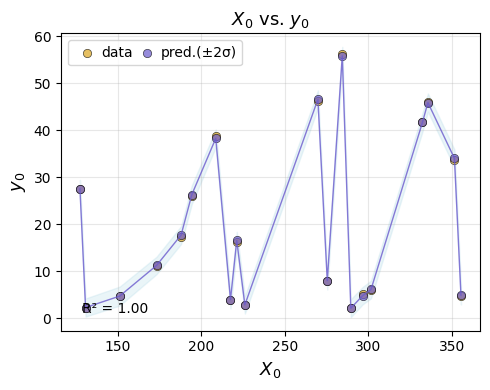

In [15]:
em.plot_eval(gp_final)

#### 9 - Sensitivity Analysis 
Use AutoEmulate to perform sensitivity analysis. This will help identify the parameters that have higher impact on the outputs to narrow down the search space for performing model calibration. 

Sobol Interpretation:

- $S_1$ values sum to ≤ 1.0 (exact fraction of variance explained)
- $S_t - S_1$ = interaction effects involving that parameter
- Large $S_t - S_1$ gap indicates strong interactions

Morris Interpretation:

- High $\mu^*$, Low $\sigma$: Important parameter with linear/monotonic effects
- High $\mu^*$, High $\sigma$: Important parameter with non-linear effects or interactions
- Low $\mu^*$, High $\sigma$: Parameter involved in interactions but not individually important
- Low $\mu^*$, Low $\sigma$: Unimportant parameter

In [16]:
# Extract parameter names and bounds from the dictionary
parameter_names = list(parameters_range.keys())
parameter_bounds = list(parameters_range.values())

# Define the problem dictionary for Sobol sensitivity analysis
problem = {
    'num_vars': len(parameter_names),
    'names': parameter_names,
    'bounds': parameter_bounds
}


In [17]:
si = em.sensitivity_analysis(problem=problem, method='sobol')
si.head()

,output,parameter,index,value,confidence
0,y1,ao.r,S1,0.000088,0.000019
1,y1,ao.c,S1,0.000075,0.000014
2,y1,art.r,S1,0.000182,0.000031
3,y1,art.c,S1,0.000311,0.000047
4,y1,ven.r,S1,0.000907,0.000155


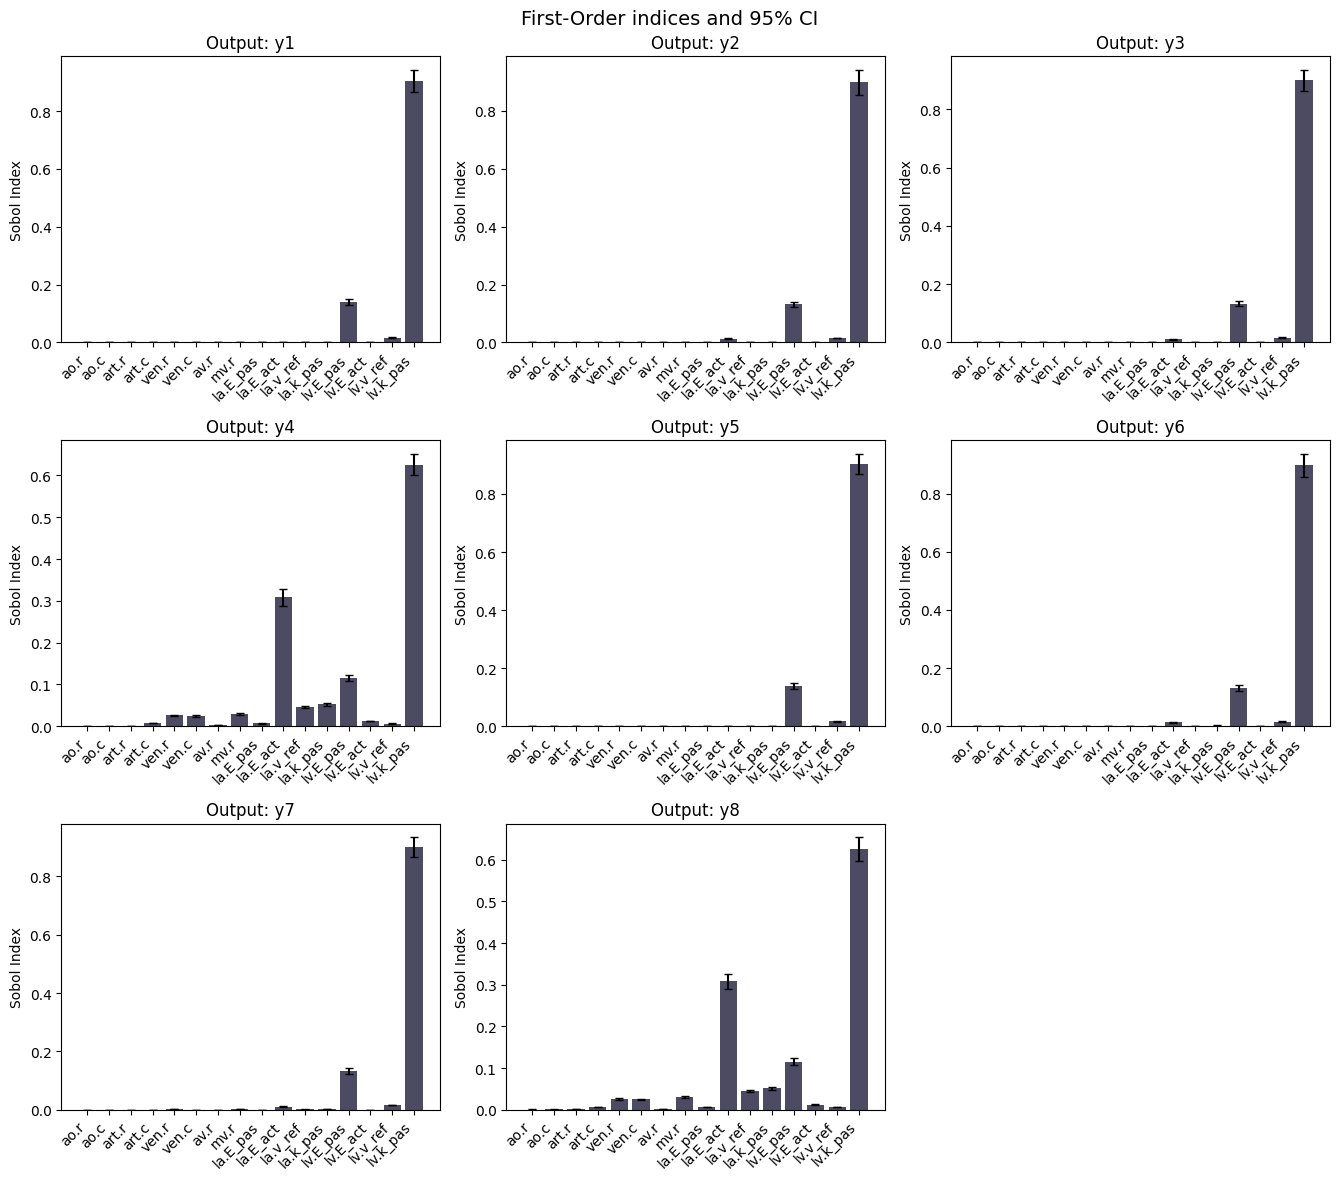

In [18]:
em.plot_sensitivity_analysis(si)


In [26]:

from autoemulate.history_matching import HistoryMatching

# Define observed data with means and variances
observations = {
    'lv.P_i_min': (5.0, 0.1),   # Minimum of minimum LV pressure
    'lv.P_i_max': (20.0, 0.1),   # Maximum of minimum LV pressure
    'lv.P_i_mean': (10.0, 0.1),  # Mean of minimum LV pressure
    'lv.P_i_range': (15.0, 0.5), # Range of minimum LV pressure
    'lv.P_o_min': (1.0, 0.1),  # Minimum of maximum LV pressure
    'lv.P_o_max': (13.0, 0.1),  # Maximum of maximum LV pressure
    'lv.P_o_mean': (12.0, 0.1), # Mean of maximum LV pressure
    'lv.P_o_range': (20.0, 0.5)  # Range of maximum LV pressure
}

# Create history matcher
hm = HistoryMatching(
    simulator=simulator,
    observations=observations,
    threshold=3.0
)

# Run history matching
all_samples, all_impl_scores, emulator = hm.run(
    n_waves=50,
    n_samples_per_wave=100,
    emulator_predict=True,
    initial_emulator=gp_final,
)

History Matching: 100%|██████████| 50/50 [00:02<00:00, 22.81wave/s, samples=85, failed=0, NROY=74, min_impl=0.26, max_impl=3.10]


In [27]:
final_results = hm.calculate_implausibility(
    pred_means=emulator.predict(all_samples),
    pred_vars=None
)
nroy_samples = all_samples[final_results["NROY"]]
nroy_indices = final_results["NROY"]

In [28]:
final_results

{'I': array([[66.12703654, 51.83714194, 76.52979001, ..., 72.94293607,
         70.49956312, 13.63791851],
        [ 6.87072079, 22.42061354,  2.86132654, ...,  1.31481942,
          3.16890035, 20.60489297],
        [22.51858469, 18.86719546, 42.31209092, ..., 39.97298958,
         36.28186403,  8.69718032],
        ...,
        [10.13884252,  7.62326276, 30.86009083, ..., 28.72905688,
         24.82986394,  8.16968736],
        [10.13884295,  7.62325522, 30.86008391, ..., 28.72904934,
         24.82985701,  8.16969106],
        [10.13884599,  7.62326328, 30.86009161, ..., 28.7290574 ,
         24.82986472,  8.16968873]]),
 'NROY': [],
 'RO': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,

#### 10 - MCMC
Once you have identified the important parameters through the Sensitivity analysis tool, the MCMC module can return the calibrated parameter values with uncertainty. 
The MCMC algorithm tries to find parameter values that match the predictions by the emulator to your `observations` whilst staying within the `parameters_range` (priors)
and accounting for uncertainty.

In [21]:
from autoemulate.mcmc import MCMCCalibrator
# Define your observations (what you want to match)
# Define observed data with means and variances


# Run calibration
calibrator = MCMCCalibrator(
    emulator=gp_final,
    sensitivity_results=si,
    observations=observations,
    parameter_bounds=parameters_range,
    nroy_samples=nroy_samples,
    nroy_indices=nroy_indices,
    all_samples=all_samples,
    top_n_params=3  # Calibrate top 5 most sensitive parameters
)

results = calibrator.run_mcmc(num_samples=500, warmup_steps=100)
# Get calibrated parameter values
calibrated_params = calibrator.get_calibrated_parameters()
calibrated_params


DEBUG: NROY samples shape: (0, 16)
DEBUG: NROY samples type: <class 'numpy.ndarray'>
DEBUG: Number of NROY samples: 0
Calibrating top 3 parameters:
  - lv.k_pas
  - lv.E_pas
  - la.E_act
Cannot use NROY initialization (no valid NROY samples). Using default initialization.
Running MCMC...


Warmup:  16%|█▌        | 94/600 [02:08,  1.33s/it, step size=4.55e-04, acc. prob=0.685]

KeyboardInterrupt: 

In [ ]:
from autoemulate.mcmc_dashboard import MCMCVisualizationDashboard
dashboard = MCMCVisualizationDashboard(calibrator)
dashboard.display()

#### 11 - History Matching
 
Once you have the final model, running history matching can improve your model. The Implausibility metric is calculated using the following relation for each set of parameter:

$I_i(\overline{x_0}) = \frac{|z_i - \mathbb{E}(f_i(\overline{x_0}))|}{\sqrt{\text{Var}[z_i - \mathbb{E}(f_i(\overline{x_0}))]}}$
Where if implosibility ($I_i$) exceeds a threshhold value, the points will be rulled out. 
The outcome of history matching are the NORY (Not Ruled Out Yet) and RO (Ruled Out) points.

- create a dictionary of your observations, this should match the output names of your simulator 
- create the history matching object 
- run history matching 


In [ ]:
em.plot_eval(emulator)

#### 10 - use the interactive dashboard to inspect the results of history matching 



In [ ]:
from autoemulate.history_matching_dashboard import HistoryMatchingDashboard
dashboard = HistoryMatchingDashboard(
    samples=all_samples,
    impl_scores=all_impl_scores,
    param_names=simulator.param_names,  
    output_names=simulator.output_names, 
    )
dashboard.display()

<img src=


"https://raw.githubusercontent.com/alan-turing-institute/autoemulate/refs/heads/main/misc/vis_dashboard_pic_sample.png" alt="Work Flow" style="width:100%;"/> """

### Footnote: Testing the dashboard

Sometimes it is hard to know, if the results we are seeing is because the code is not working, or our simulation results are more interesting than we expected. Here is a little test dataset which tests the dashboard, so that you can see how the plots are supposed to look liek and what they shouldf show

In [ ]:
# Create a test sample with KNOWN NROY regions
test_samples = np.array([[x, y] for x in np.linspace(0,1,100) 
                               for y in np.linspace(0,1,100)])
test_scores = (abs(test_samples[:, 0]-0.5)+abs(test_samples[:, 1]-0.5)).reshape(-1, 1)

# Should show a clear diagonal pattern
test_dash = HistoryMatchingDashboard(
    samples=test_samples,
    impl_scores=test_scores,
    param_names=["p1", "p2"],
    output_names=["out1"],
    threshold=0.7  # ~50% of points should be NROY
)
#test_dash.display()